In [27]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torchvision.transforms.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data.dataset import random_split

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# Directorios de entrenamiento y prueba
train_data_dir ='/content/drive/MyDrive/IA_2023_CI_Bolivar_Rodriguez/Proyecto/Proyecto_2do_parcial/xray_dataset_covid19/train'
test_data_dir = '/content/drive/MyDrive/IA_2023_CI_Bolivar_Rodriguez/Proyecto/Proyecto_2do_parcial/xray_dataset_covid19/test'

In [30]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Cambios aleatorios en el color
    transforms.RandomHorizontalFlip(),  # Voltear horizontalmente de manera aleatoria
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [31]:
# Cargar los datos completos
full_dataset = ImageFolder(train_data_dir, transform=transform)

In [32]:
# Calcular los tamaños de los conjuntos de entrenamiento, validación y prueba
total_samples = len(full_dataset)
train_size = int(0.7 * total_samples)
test_size = int(0.4 * total_samples)
val_size = total_samples - (train_size + test_size)

In [33]:
# Dividir el conjunto completo en entrenamiento, validación y prueba
train_subset, val_subset, test_subset = random_split(full_dataset, [train_size, val_size, test_size])
# Crear los DataLoaders para los nuevos conjuntos
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64)
test_loader = DataLoader(test_subset, batch_size=64)

In [34]:
# Definición del modelo CNN
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 17 * 17, 512),
            nn.ReLU(),
            nn.Dropout(0.2),  # Aumento de tasa de dropout
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [35]:
# Instanciar el modelo y definir la función de pérdida y el optimizador
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

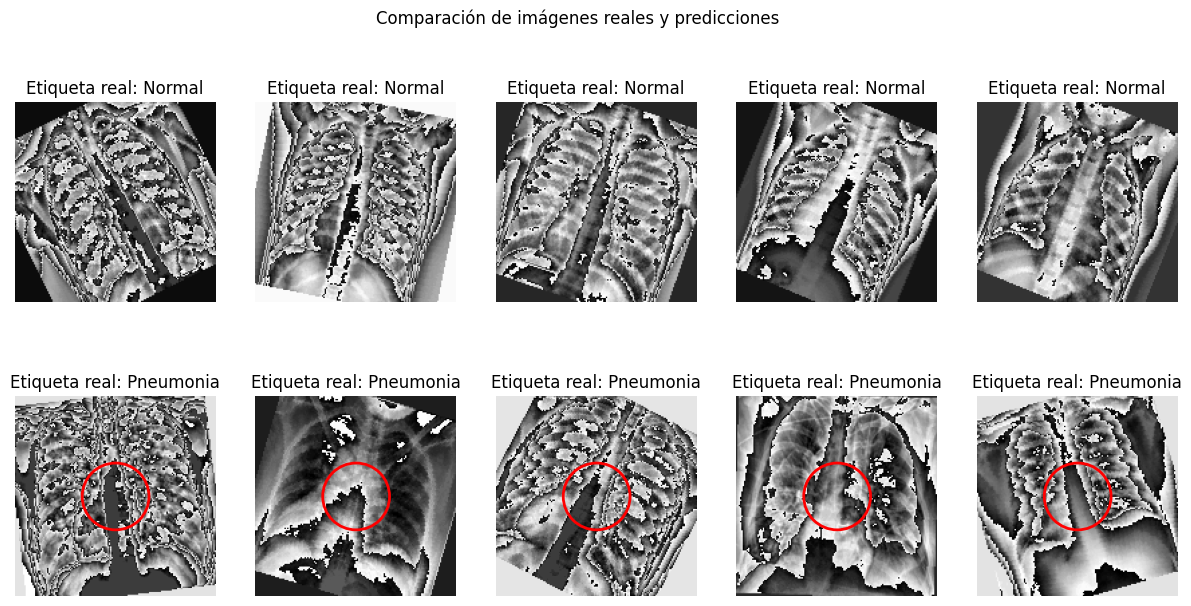

In [36]:
# Define la función de visualización de predicciones y etiquetas reales
def visualize_predictions(model, test_loader, num_samples=5):
    count_normal = 0
    count_pneumonia = 0

    with torch.no_grad():
        fig, axs = plt.subplots(2, num_samples, figsize=(15, 7))
        fig.suptitle('Comparación de imágenes reales y predicciones')

        for i, (images, labels) in enumerate(test_loader):
            if count_normal >= num_samples and count_pneumonia >= num_samples:
                break

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            for j in range(images.size(0)):
                label_str = 'Normal' if labels[j] == 0 else 'Pneumonia'

                transformed_image = F.to_pil_image(images[j][0])

                if labels[j] == 0 and count_normal < num_samples:
                    axs[0, count_normal].imshow(transformed_image, cmap='gray')
                    axs[0, count_normal].set_title(f'Etiqueta real: {label_str}')
                    axs[0, count_normal].axis('off')
                    count_normal += 1
                elif labels[j] == 1 and count_pneumonia < num_samples:
                    axs[1, count_pneumonia].imshow(transformed_image, cmap='gray')
                    axs[1, count_pneumonia].set_title(f'Etiqueta real: {label_str}')
                    axs[1, count_pneumonia].axis('off')

                    # Para zoom en una imagen, multiplicamos sus dimensiones por el factor de zoom
                    radius = int(transformed_image.size[0] / 6)
                    center_x = transformed_image.size[0] // 2
                    center_y = transformed_image.size[1] // 2
                    circle_color = 'red'  # Color del círculo
                    circle_thickness = 2  # Grosor del círculo
                    # Crear el objeto de círculo con las coordenadas y características definidas
                    circle = plt.Circle((center_x, center_y), radius, color=circle_color, fill=False, linewidth=circle_thickness)
                    # Agregar el círculo a la imagen
                    axs[1, count_pneumonia].add_patch(circle)

                    count_pneumonia += 1

# Llamada a la función de visualización de predicciones y etiquetas reales
visualize_predictions(model, test_loader, num_samples=5)

In [37]:
# Entrenamiento del modelo
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

Epoch [1/10], Loss: 2.3756730556488037
Epoch [2/10], Loss: 0.7200921773910522
Epoch [3/10], Loss: 0.6580442786216736
Epoch [4/10], Loss: 0.5197259783744812
Epoch [5/10], Loss: 0.44073083996772766
Epoch [6/10], Loss: 0.4817903935909271
Epoch [7/10], Loss: 0.26677656173706055
Epoch [8/10], Loss: 0.298500120639801
Epoch [9/10], Loss: 0.2910396456718445
Epoch [10/10], Loss: 0.2040165662765503


In [38]:
# Evaluación del modelo en el conjunto de prueba
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = (outputs >= 0.5).squeeze().long()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
# Calcular exactitud (accuracy)
accuracy = accuracy_score(y_true, y_pred)
print("Exactitud (Accuracy): {:.2f}%".format(accuracy * 100))

Exactitud (Accuracy): 93.22%


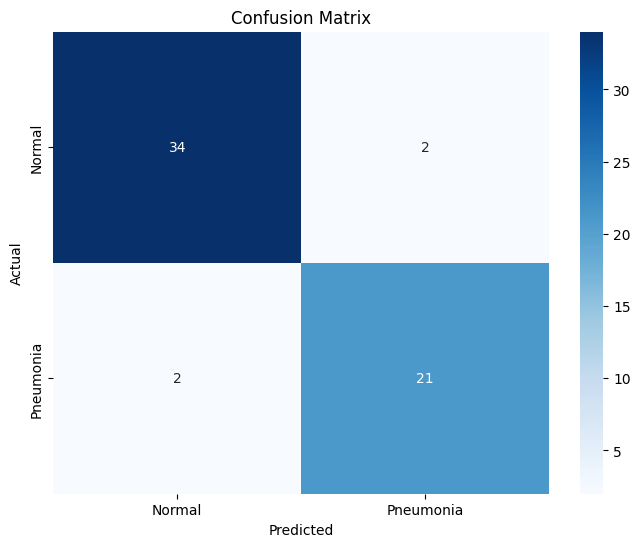

In [40]:
# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
# Etiquetas de las clases
target_names = ['Normal', 'Pneumonia']

# Mostrar la matriz de confusión utilizando seaborn y matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()